# **Prétraitement du texte**

Constitution des corpus, nettoyage, prétraitements en amont du BagOfWords

# Corpus `product_name`

,2,3,4,5,6,7,8,9,10,11,...,14,15,16,17,18,19,20,22,24,30
freq,36,13,105,122,128,159,154,108,81,36,...,14,15,3,3,2,3,1,1,1,1


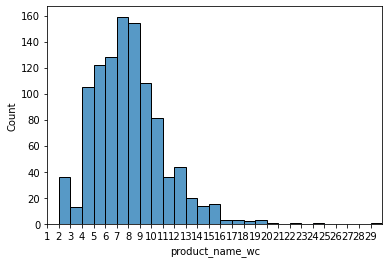

In [ ]:
import pandas as pd
from flipkart_utils import (
    get_raw_tokenized_product_names,
    get_word_count,
    display_word_count_dist,
    show_word_count_dist
)
product_names = get_raw_tokenized_product_names()
word_count = get_word_count(product_names)
display_word_count_dist(word_count)
show_word_count_dist(word_count)

In [ ]:
from flipkart_utils import (
    get_raw_tokenized_product_names,
    get_lexicon_dict,
    get_lexicon_dataframe
)

product_names = get_raw_tokenized_product_names()

product_names_lexicon = get_lexicon_dict(product_names)
print('taille du lexique :', len(product_names_lexicon))

display(product_names_lexicon)

lexicon_data = get_lexicon_dataframe(product_names)
display(lexicon_data)

taille du lexique : 2525


{'Elegance': 2,
 'Polyester': 21,
 'Multicolor': 29,
 'Abstract': 37,
 'Eyelet': 19,
 'Door': 16,
 'Curtain': 20,
 'Sathiyas': 1,
 'Cotton': 54,
 'Bath': 18,
 'Towel': 23,
 'Eurospa': 1,
 'Terry': 2,
 'Face': 9,
 'Set': 129,
 'SANTOSH': 2,
 'ROYAL': 2,
 'FASHION': 2,
 'Printed': 29,
 'King': 10,
 'sized': 4,
 'Double': 40,
 'Bedsheet': 11,
 'Jaipur': 5,
 'Print': 13,
 'Floral': 27,
 'Maserati': 1,
 'Time': 2,
 'R8851116001': 1,
 'Analog': 127,
 'Watch': 150,
 '-': 286,
 'For': 156,
 'Boys': 35,
 'Camerii': 1,
 'WM64': 1,
 'Men': 78,
 ',': 111,
 'T': 1,
 'STAR': 1,
 'UFT-TSW-005-BK-BR': 1,
 'Alfajr': 2,
 'WY16B': 1,
 'Youth': 1,
 'Digital': 18,
 'TAG': 1,
 'Heuer': 1,
 'CAU1116.BA0858': 1,
 'Formula': 1,
 '1': 8,
 'Calibro': 1,
 'SW-125': 1,
 'Analog-Digital': 4,
 'Cartier': 1,
 'W6701005': 1,
 'Lois': 1,
 'Caron': 1,
 'LCS-4032': 1,
 'Titan': 1,
 '1639SL03': 1,
 'Srushti': 1,
 'Art': 12,
 'Jewelry': 1,
 'Megnet_Led_Sport_BlackRed1': 1,
 'Women': 55,
 'Girls': 19,
 'Escort': 1,
 'E-1700

,word,freq,len
product_name,,,
0,Elegance,2,8
1,Polyester,21,9
2,Multicolor,29,10
3,Abstract,37,8
4,Eyelet,19,6
...,...,...,...
2520,Uberlyfe,2,8
2521,Pigmented,1,9
2522,Polyvinyl,1,9


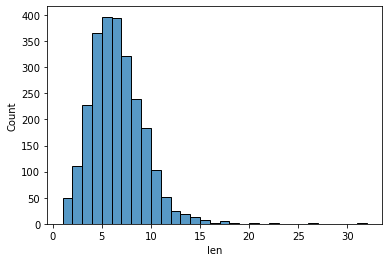

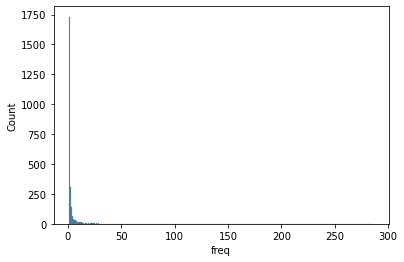

In [ ]:
from flipkart_utils import (
    get_raw_tokenized_product_names,
    get_lexicon_dataframe,
    show_lexicon_dist
)

product_names = get_raw_tokenized_product_names()
lexicon_data = get_lexicon_dataframe(product_names)
show_lexicon_dist(lexicon_data, 'len')
show_lexicon_dist(lexicon_data, 'freq')

TODO : Pas fait sur la passe précédente : qualifier : ponctuation, stopword, etc : simplement ajouter des colonnes supplémentaires.

TODO : Il serait aussi intéressant de faire le 2D freq / len

In [ ]:
display(lexicon_data)

,word,freq,len
product_name,,,
0,Elegance,2,8
1,Polyester,21,9
2,Multicolor,29,10
3,Abstract,37,8
4,Eyelet,19,6
...,...,...,...
2520,Uberlyfe,2,8
2521,Pigmented,1,9
2522,Polyvinyl,1,9


In [ ]:
casefolded_words = lexicon_data.word.str.casefold()
print('casefolded nunique:', casefolded_words.nunique())
#display(casefolded_words)
lexicon_data['casefolded_word'] = casefolded_words
display(lexicon_data)

casefolded nunique: 2398


,word,freq,len,casefolded_word
product_name,,,,
0,Elegance,2,8,elegance
1,Polyester,21,9,polyester
2,Multicolor,29,10,multicolor
3,Abstract,37,8,abstract
4,Eyelet,19,6,eyelet
...,...,...,...,...
2520,Uberlyfe,2,8,uberlyfe
2521,Pigmented,1,9,pigmented
2522,Polyvinyl,1,9,polyvinyl


Stopwords

In [ ]:
# from nltk.corpus import stopwords
# nltk_stopwords_en = stopwords.words('english')
from flipkart_utils import is_stopword_en
is_stopword = is_stopword_en(lexicon_data.word)  # casefolded_words.isin(nltk_stopwords_en)
print('# stopwords:', is_stopword.sum())
#display(casefolded_words)
lexicon_data['is_stopword_en'] = is_stopword
display(lexicon_data)

# stopwords: 12


,word,freq,len,casefolded_word,is_stopword_en
product_name,,,,,
0,Elegance,2,8,elegance,False
1,Polyester,21,9,polyester,False
2,Multicolor,29,10,multicolor,False
3,Abstract,37,8,abstract,False
4,Eyelet,19,6,eyelet,False
...,...,...,...,...,...
2520,Uberlyfe,2,8,uberlyfe,False
2521,Pigmented,1,9,pigmented,False
2522,Polyvinyl,1,9,polyvinyl,False


Numérique entier, alpha majuscules
... Le mieux me semble de travailler dans une Google Sheet puis de revenir au code ensuite.
Il faut donc commencer par sortir mes CSV raw

In [ ]:
from flipkart_utils import save_dataframe
display(lexicon_data)
save_dataframe(lexicon_data, 'product_name_lexicon')

,word,freq,len,casefolded_word,is_stopword_en
product_name,,,,,
0,Elegance,2,8,elegance,False
1,Polyester,21,9,polyester,False
2,Multicolor,29,10,multicolor,False
3,Abstract,37,8,abstract,False
4,Eyelet,19,6,eyelet,False
...,...,...,...,...,...
2520,Uberlyfe,2,8,uberlyfe,False
2521,Pigmented,1,9,pigmented,False
2522,Polyvinyl,1,9,polyvinyl,False


In [ ]:
from flipkart_utils import is_integer, is_upper_alpha

is_int = is_integer(lexicon_data.word)
print('# integers', is_int.sum())
display(is_int)

is_upper = is_upper_alpha(lexicon_data.word)
print('# upper_alpha', is_upper.sum())
display(is_upper)

# integers 248


product_name
0       False
1       False
2       False
3       False
4       False
        ...  
2520    False
2521    False
2522    False
2523    False
2524    False
Name: word, Length: 2525, dtype: bool

# upper_alpha 2112


product_name
0       True
1       True
2       True
3       True
4       True
        ... 
2520    True
2521    True
2522    True
2523    True
2524    True
Name: word, Length: 2525, dtype: bool

Mots de longueur $n$

In [ ]:
display(lexicon_data[lexicon_data.len == 1].sort_values(by='freq', ascending=False))

,word,freq,len,casefolded_word,is_stopword_en
product_name,,,,,
31,-,286,1,-,False
37,",",111,1,",",False
155,&,75,1,&,False
141,6,28,1,6,False
278,),26,1,),False
274,(,26,1,(,False
788,L,25,1,l,False
199,4,17,1,4,False
277,2,14,1,2,False


In [ ]:
from flipkart_utils import show_n_grams

show_n_grams(lexicon_data, 1)

nombre de 1-grammes : 50


array(['!', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '1', '2',
       '3', '4', '5', '6', '7', '8', '9', ':', '?', '@', 'A', 'B', 'C',
       'D', 'E', 'G', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
       'U', 'V', 'W', 'X', 'e', 'g', 'n', 'r', 's', 'x', '�'],
      dtype=object)

,word,freq,len,casefolded_word,is_stopword_en
product_name,,,,,
31,-,286,1,-,False
37,",",111,1,",",False
155,&,75,1,&,False
141,6,28,1,6,False
278,),26,1,),False
274,(,26,1,(,False
788,L,25,1,l,False
199,4,17,1,4,False
277,2,14,1,2,False


### Nouvelle passe avec inclusion de la racinisation et de la lemmatisation

In [ ]:
display(lexicon_data)

,word,freq,len,casefolded_word,is_stopword_en
product_name,,,,,
0,Elegance,2,8,elegance,False
1,Polyester,21,9,polyester,False
2,Multicolor,29,10,multicolor,False
3,Abstract,37,8,abstract,False
4,Eyelet,19,6,eyelet,False
...,...,...,...,...,...
2520,Uberlyfe,2,8,uberlyfe,False
2521,Pigmented,1,9,pigmented,False
2522,Polyvinyl,1,9,polyvinyl,False


In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stem = lexicon_data.casefolded_word.apply(lambda x: stemmer.stem(x))
display(stem)

product_name
0             eleg
1          polyest
2       multicolor
3         abstract
4           eyelet
           ...    
2520       uberlyf
2521       pigment
2522     polyvinyl
2523          film
2524        import
Name: casefolded_word, Length: 2525, dtype: object

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lem = lexicon_data.casefolded_word.apply(lambda x: lemmatizer.lemmatize(x))
display(lem)

product_name
0         elegance
1        polyester
2       multicolor
3         abstract
4           eyelet
           ...    
2520      uberlyfe
2521     pigmented
2522     polyvinyl
2523          film
2524      imported
Name: casefolded_word, Length: 2525, dtype: object

Enregistrement

In [ ]:
from flipkart_utils import save_dataframe
lexicon_data['stem'] = stem
lexicon_data['lem'] = lem
display(lexicon_data)
save_dataframe(lexicon_data, 'product_name_lexicon')

,word,freq,len,casefolded_word,is_stopword_en,stem,lem
product_name,,,,,,,
0,Elegance,2,8,elegance,False,eleg,elegance
1,Polyester,21,9,polyester,False,polyest,polyester
2,Multicolor,29,10,multicolor,False,multicolor,multicolor
3,Abstract,37,8,abstract,False,abstract,abstract
4,Eyelet,19,6,eyelet,False,eyelet,eyelet
...,...,...,...,...,...,...,...
2520,Uberlyfe,2,8,uberlyfe,False,uberlyf,uberlyfe
2521,Pigmented,1,9,pigmented,False,pigment,pigmented
2522,Polyvinyl,1,9,polyvinyl,False,polyvinyl,polyvinyl


# Corpus `product_category_tree`

TODO : ajouter un tri, d'abord par fréquence, puis par ordre lexico, du level 0 vers le 6

In [ ]:
from flipkart_utils import get_product_category_branches, save_dataframe
cats = get_product_category_branches().reset_index()
display(cats.head())
save_dataframe(cats, 'product_category_tree')

,Flipkart,level_0,level_1,level_2,level_3,level_4,level_5,level_6
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,None,None,None
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...",None,None
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE ...,None,None
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,None,None
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double B...,None,None
...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,Baby Care,Baby & Kids Gifts,Stickers,Oren Empower Stickers,None,None,None
1046,fd6cbcc22efb6b761bd564c28928483c,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,None,None,None
1047,5912e037d12774bb73a2048f35a00009,Baby Care,Baby & Kids Gifts,Stickers,Uberlyfe Stickers,None,None,None
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,None,None,None


Il faut en plus sortir :
1. le corpus des noms de catégories en tant que phrases
    * pour chacune, les niveaux dans lesquels elles apparaissent (en fréquence)
    * leur fréquence totale tous niveaux confondus
    * la longueur en mots
    * casefold
    * racinisation
    * lemmatisation

2. tolenizer en mots et faire la même chose

# Corpus `description`

Pas vraiment fait en première passe.

Faire :
* découpage en phrases
* découpage des phrases en mots
* c'est laborieux...

In [ ]:
from nltk import sent_tokenize
from flipkart_utils import get_raw_data
desc = get_raw_data('description')
display(desc)

def get_sentences(desc):
    return desc.apply(sent_tokenize)

desc_sents = get_sentences(desc)
display(desc_sents)

Flipkart
55b85ea15a1536d46b7190ad6fff8ce7    Key Features of Elegance Polyester Multicolor ...
7b72c92c2f6c40268628ec5f14c6d590    Specifications of Sathiyas Cotton Bath Towel (...
64d5d4a258243731dc7bbb1eef49ad74    Key Features of Eurospa Cotton Terry Face Towe...
d4684dcdc759dd9cdf41504698d737d8    Key Features of SANTOSH ROYAL FASHION Cotton P...
6325b6870c54cd47be6ebfbffa620ec7    Key Features of Jaipur Print Cotton Floral Kin...
                                                          ...                        
958f54f4c46b53c8a0a9b8167d9140bc    Oren Empower Extra Large Self Adhesive Sticker...
fd6cbcc22efb6b761bd564c28928483c    Wallmantra Large Vinyl Sticker Sticker (Pack o...
5912e037d12774bb73a2048f35a00009    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
c3edc504d1b4f0ba6224fa53a43a7ad6    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
f2f027ad6a6df617c9f125173da71e44    Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
Name: description, Length: 1050, dtype: objec

Flipkart
55b85ea15a1536d46b7190ad6fff8ce7    [Key Features of Elegance Polyester Multicolor...
7b72c92c2f6c40268628ec5f14c6d590    [Specifications of Sathiyas Cotton Bath Towel ...
64d5d4a258243731dc7bbb1eef49ad74    [Key Features of Eurospa Cotton Terry Face Tow...
d4684dcdc759dd9cdf41504698d737d8    [Key Features of SANTOSH ROYAL FASHION Cotton ...
6325b6870c54cd47be6ebfbffa620ec7    [Key Features of Jaipur Print Cotton Floral Ki...
                                                          ...                        
958f54f4c46b53c8a0a9b8167d9140bc    [Oren Empower Extra Large Self Adhesive Sticke...
fd6cbcc22efb6b761bd564c28928483c    [Wallmantra Large Vinyl Sticker Sticker (Pack ...
5912e037d12774bb73a2048f35a00009    [Buy Uberlyfe Extra Large Pigmented Polyvinyl ...
c3edc504d1b4f0ba6224fa53a43a7ad6    [Buy Wallmantra Medium Vinyl Sticker Sticker f...
f2f027ad6a6df617c9f125173da71e44    [Buy Uberlyfe Large Vinyl Sticker for Rs.595 o...
Name: description, Length: 1050, dtype: objec

On met à plat par expansion verticale :

In [ ]:
import pandas as pd
#flat_desc_sents = pd.DataFrame(desc_sents.explode().reset_index())
#flat_desc_sents.columns = ['prod_id', 'sent_id', 'sent']
#display(flat_desc_sents)
desc_sents.index.name = 'product_id'
x = desc_sents.reset_index()
x.insert(1, 'sentence_id', x.description.apply(lambda x: list(range(len(x)))))
y = x.explode(['sentence_id', 'description'], ignore_index=True)
display(y) #.explode('description'))


,product_id,sentence_id,description
0,55b85ea15a1536d46b7190ad6fff8ce7,0,Key Features of Elegance Polyester Multicolor ...
1,55b85ea15a1536d46b7190ad6fff8ce7,1,899 This curtain enhances the look of the inte...
2,55b85ea15a1536d46b7190ad6fff8ce7,2,The surreal attention is sure to steal hearts.
3,55b85ea15a1536d46b7190ad6fff8ce7,3,These contemporary eyelet and valance curtains...
4,55b85ea15a1536d46b7190ad6fff8ce7,4,Bring home the elegant curtain that softly fil...
...,...,...,...
5191,c3edc504d1b4f0ba6224fa53a43a7ad6,3,30 Day Replacement Guarantee.
5192,f2f027ad6a6df617c9f125173da71e44,0,Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
5193,f2f027ad6a6df617c9f125173da71e44,1,Uberlyfe Large Vinyl Sticker at best prices wi...
5194,f2f027ad6a6df617c9f125173da71e44,2,Only Genuine Products.


On re-parse cette fois-ci pour découper chaque phrase en mots

In [ ]:
from nltk import word_tokenize
desc_words = y.description.apply(word_tokenize)
display(desc_words)

0       [Key, Features, of, Elegance, Polyester, Multi...
1       [899, This, curtain, enhances, the, look, of, ...
2       [The, surreal, attention, is, sure, to, steal,...
3       [These, contemporary, eyelet, and, valance, cu...
4       [Bring, home, the, elegant, curtain, that, sof...
                              ...                        
5191                 [30, Day, Replacement, Guarantee, .]
5192    [Buy, Uberlyfe, Large, Vinyl, Sticker, for, Rs...
5193    [Uberlyfe, Large, Vinyl, Sticker, at, best, pr...
5194                         [Only, Genuine, Products, .]
5195                 [30, Day, Replacement, Guarantee, .]
Name: description, Length: 5196, dtype: object

Et on réitère le explode pour disposer des 'coordonnées de chaque mot :

In [ ]:
import pandas as pd
z = pd.concat([y.product_id, y.sentence_id, desc_words], axis=1)
z.insert(2, 'word_id', desc_words.apply(lambda x: list(range(len(x)))))
z = z.explode(['word_id', 'description'], ignore_index=True)
display(z)

,product_id,sentence_id,word_id,description
0,55b85ea15a1536d46b7190ad6fff8ce7,0,0,Key
1,55b85ea15a1536d46b7190ad6fff8ce7,0,1,Features
2,55b85ea15a1536d46b7190ad6fff8ce7,0,2,of
3,55b85ea15a1536d46b7190ad6fff8ce7,0,3,Elegance
4,55b85ea15a1536d46b7190ad6fff8ce7,0,4,Polyester
...,...,...,...,...
91608,f2f027ad6a6df617c9f125173da71e44,3,0,30
91609,f2f027ad6a6df617c9f125173da71e44,3,1,Day
91610,f2f027ad6a6df617c9f125173da71e44,3,2,Replacement
91611,f2f027ad6a6df617c9f125173da71e44,3,3,Guarantee


word, freq, len, casefold, stopword :

In [ ]:
import pandas as pd
from flipkart_utils import is_stopword_en

lex = z.description.value_counts().reset_index()
lex.columns = ['word', 'freq']
lex['len'] = lex.word.apply(len)
lex['casefolded_word'] = lex.word.str.casefold()
lex['is_stopword'] = is_stopword_en(lex.word)
display(lex)

,word,freq,len,casefolded_word,is_stopword
0,.,4257,1,.,False
1,",",3133,1,",",False
2,of,1659,2,of,True
3,and,1167,3,and,True
4,the,1015,3,the,True
...,...,...,...,...,...
8161,threadwork,1,10,threadwork,False
8162,"1,700",1,5,"1,700",False
8163,590,1,3,590,False
8164,Move,1,4,move,False


Sauvegarde (de la v1) v2 : ajout stem et lem

In [ ]:
from flipkart_utils import save_dataframe

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
lex['stem'] = lex.casefolded_word.apply(lambda x: stemmer.stem(x))

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lex['lem'] = lex.casefolded_word.apply(lambda x: lemmatizer.lemmatize(x))

display(lex)
save_dataframe(lex, 'description')

,word,freq,len,casefolded_word,is_stopword,stem,lem
0,.,4257,1,.,False,.,.
1,",",3133,1,",",False,",",","
2,of,1659,2,of,True,of,of
3,and,1167,3,and,True,and,and
4,the,1015,3,the,True,the,the
...,...,...,...,...,...,...,...
8161,threadwork,1,10,threadwork,False,threadwork,threadwork
8162,"1,700",1,5,"1,700",False,"1,700","1,700"
8163,590,1,3,590,False,590,590
8164,Move,1,4,move,False,move,move


### Tagging POS : sur la base des phrases

Le fait de travailler sur des phrases comportant de nombreux mots à tort capitalisés nuit à la bonne analyse. Des noms communs ressortent comme noms propres du fait d'être capitalisés.

In [ ]:
import pandas as pd
sentences = y.copy()
sentences.description = desc_words
display(sentences)

,product_id,sentence_id,description
0,55b85ea15a1536d46b7190ad6fff8ce7,0,"[Key, Features, of, Elegance, Polyester, Multi..."
1,55b85ea15a1536d46b7190ad6fff8ce7,1,"[899, This, curtain, enhances, the, look, of, ..."
2,55b85ea15a1536d46b7190ad6fff8ce7,2,"[The, surreal, attention, is, sure, to, steal,..."
3,55b85ea15a1536d46b7190ad6fff8ce7,3,"[These, contemporary, eyelet, and, valance, cu..."
4,55b85ea15a1536d46b7190ad6fff8ce7,4,"[Bring, home, the, elegant, curtain, that, sof..."
...,...,...,...
5191,c3edc504d1b4f0ba6224fa53a43a7ad6,3,"[30, Day, Replacement, Guarantee, .]"
5192,f2f027ad6a6df617c9f125173da71e44,0,"[Buy, Uberlyfe, Large, Vinyl, Sticker, for, Rs..."
5193,f2f027ad6a6df617c9f125173da71e44,1,"[Uberlyfe, Large, Vinyl, Sticker, at, best, pr..."
5194,f2f027ad6a6df617c9f125173da71e44,2,"[Only, Genuine, Products, .]"


In [ ]:
import nltk
pos_tags = sentences.description.apply(nltk.pos_tag)
display(pos_tags)

0       [(Key, NNP), (Features, NNP), (of, IN), (Elega...
1       [(899, CD), (This, DT), (curtain, NN), (enhanc...
2       [(The, DT), (surreal, JJ), (attention, NN), (i...
3       [(These, DT), (contemporary, JJ), (eyelet, NN)...
4       [(Bring, NNP), (home, NN), (the, DT), (elegant...
                              ...                        
5191    [(30, CD), (Day, NNP), (Replacement, NNP), (Gu...
5192    [(Buy, NNP), (Uberlyfe, NNP), (Large, NNP), (V...
5193    [(Uberlyfe, NNP), (Large, NNP), (Vinyl, NNP), ...
5194    [(Only, RB), (Genuine, JJ), (Products, NNPS), ...
5195    [(30, CD), (Day, NNP), (Replacement, NNP), (Gu...
Name: description, Length: 5196, dtype: object

In [ ]:
from flipkart_utils import full_show_sample
full_show_sample(pos_tags, n=5)

(1883, [('Free', 'JJ'), ('Shipping', 'NN'), ('.', '.')])

(5169,
 [('You', 'PRP'),
  ('can', 'MD'),
  ('apply', 'VB'),
  ('these', 'DT'),
  ('yourself', 'PRP'),
  ('.', '.')])

(1199,
 [('King', 'VBG'),
  ('International', 'NNP'),
  ('Ergonomic', 'NNP'),
  ('Design', 'NNP'),
  ('with', 'IN'),
  ('Long', 'NNP'),
  ('Gripped', 'NNP'),
  ('Handle', 'NNP'),
  ('Rolling', 'NNP'),
  ('Pizza', 'NNP'),
  ('Cutter', 'NNP'),
  ('(', '('),
  ('Stainless', 'NNP'),
  ('Steel', 'NNP'),
  ('Pack', 'NNP'),
  ('of', 'IN'),
  ('1', 'CD'),
  (')', ')'),
  ('Price', 'NN'),
  (':', ':'),
  ('Rs', 'NNP'),
  ('.', '.')])

(3349, [('0.0', 'CD'), ('from', 'IN'), ('Flipkart.com', 'NNP'), ('.', '.')])

(3315,
 [('Buy', 'NNP'),
  ('Soy', 'NNP'),
  ('Impulse', 'NNP'),
  ('LED', 'NNP'),
  ('Bulb', 'NNP'),
  ('for', 'IN'),
  ('Rs.299', 'NNP'),
  ('online', 'NN'),
  ('.', '.')])

In [ ]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

### Next step : chunking et chinking

# Corpus `brand`

Le plus trivial à former, il pourra avoir son utilité, notamment pour tagger les occurrences de la marque dans le texte des descriptions, arbre de catégories et spécifications.

In [ ]:
from flipkart_utils import get_raw_data, save_dataframe
brand = get_raw_data('brand')
brand_lex = brand.value_counts(ascending=False).reset_index()
brand_lex.columns = ['expression', 'freq']
brand_lex['casefolded_expression'] = brand_lex.expression.str.casefold()
display(brand_lex)
save_dataframe(brand_lex, 'brand')
#brand.value_counts(ascending=False).reset_index().plot()

,expression,freq,casefolded_expression
0,PRINT SHAPES,11,print shapes
1,Lapguard,11,lapguard
2,Lal Haveli,10,lal haveli
3,Raymond,8,raymond
4,Aroma Comfort,8,aroma comfort
...,...,...,...
485,Rute,1,rute
486,NAMS,1,nams
487,JewelKraft Designs,1,jewelkraft designs
488,Budding Bees,1,budding bees
